<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Pixel-CMDs" data-toc-modified-id="Pixel-CMDs-1">Pixel-CMDs</a></span></li><li><span><a href="#Background" data-toc-modified-id="Background-2">Background</a></span><ul class="toc-item"><li><span><a href="#Integrated-Stellar-Populations" data-toc-modified-id="Integrated-Stellar-Populations-2.1">Integrated Stellar Populations</a></span></li><li><span><a href="#Integrated-Stellar-Populations" data-toc-modified-id="Integrated-Stellar-Populations-2.2">Integrated Stellar Populations</a></span></li><li><span><a href="#Resolved-Stellar-Populations" data-toc-modified-id="Resolved-Stellar-Populations-2.3">Resolved Stellar Populations</a></span></li><li><span><a href="#Resolved-Stellar-Populations" data-toc-modified-id="Resolved-Stellar-Populations-2.4">Resolved Stellar Populations</a></span></li><li><span><a href="#Resolved-Stellar-Populations" data-toc-modified-id="Resolved-Stellar-Populations-2.5">Resolved Stellar Populations</a></span></li><li><span><a href="#Semi-Resolved-Stellar-Populations" data-toc-modified-id="Semi-Resolved-Stellar-Populations-2.6">Semi-Resolved Stellar Populations</a></span></li></ul></li><li><span><a href="#The-Basic-Model" data-toc-modified-id="The-Basic-Model-3">The Basic Model</a></span></li><li><span><a href="#Testing-against-Complex-Data" data-toc-modified-id="Testing-against-Complex-Data-4">Testing against Complex Data</a></span></li></ul></div>

In [2]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl, seaborn as sns
import pandas as pd
import pcmdpy as ppy
%matplotlib inline

GPU acceleration not available, sorry
No module named 'pycuda'


In [3]:
sns.set_context('poster')

In [4]:
try:
    ppy.gpu_utils.initialize_gpu(n=0)
    GPU_AVAIL = True
except:
    GPU_AVAIL = False

Can't initialize GPU, _GPU_AVAIL is set to False


In [5]:
f = ppy.instrument.m31_filters()
iso_model = ppy.isochrones.Isochrone_Model(f)
driv = ppy.driver.Driver(iso_model, gpu=GPU_AVAIL)

In [6]:
def plot_pcmd(pcmd, bins=100, norm=mpl.colors.LogNorm(), ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    g = ppy.galaxy.DefaultSSP.get_model(np.array([0., -2., 2., 10.]))
    ax.hist2d(pcmd[1], pcmd[0], bins=bins, norm=norm, normed=True)
    iso_model.plot_isochrone(g, axes=ax)
    if title is not None:
        ax.set_title(title)
    return ax

In [7]:
def plot_model(model, N_im=256, **plot_kwargs):
    pcmd, _ = driv.simulate(model, N_im)
    return plot_pcmd(pcmd, **plot_kwargs)

# Pixel-CMDs

Ben Cook

Conroy Group Meeting 

21 March 2018

# Background

Observing a galaxy (photometry, spectra maybe, etc.)

Our goal is generically to measure its:

* Stellar Mass
* Metal Abundances
* Star Formation History
* Dust Content
* ...

A galaxy's light is (primarily) contributed by the stars it contains.

So, we combine our knowledge of stars and their evolution into understanding galaxies.

** Stellar Population Synthesis **

## Integrated Stellar Populations 
or: SED Modelling

<img src="phot_agn_only.jpg" width=800 />  **Leja et al. 2018**

## Integrated Stellar Populations 

* Can assume fully-populated isochrones
* Typically need wide spectral coverage
* Uncertanties come from rare, highly-evolved phases of stellar evolution (+AGN, dust, ...)

## Resolved Stellar Populations
or: CMD modelling
** M13 (as seen by HST)**
<img src="M13.jpg" width=600/>

## Resolved Stellar Populations
<img src="cmd.gif" width=600/>

## Resolved Stellar Populations

* Observe individual stars, and compare to isochrone models
* Often only need 2 colors to measure metallicity, SFH
* Limited by spatial resolution (crowding) and exposure (faintness limit)

## Semi-Resolved Stellar Populations
or: Pixel-CMDs

We're studying the intermediate regime, where:
* Can't resolve individual stars (crowding limited)
* Can't assume isochrones are fully populated (surface-brightness fluctuations)

It makes sense to describe systems by $N_{pix}$: the typical number of stars per pixel

* Resolved CMDs: $N_{pix} \ll 1$
* Semi-Resolved Stellar Populations: $N_{pix} \sim 1 \rightarrow 10^{7}$
* Integrated Stellar Populations: $N_{pix} \gg 10^7$

Due to Poisson fluctuations, some pixels will have fewer bright-rare stars than others.

* Surface-brightness fluctuations contain information!

**M31 Bulge (PHAT survey)**
<img src="M31-PHAT-Mosaic-A-2.jpg" width=600/>

What is the distribution of colors and magnitudes on a pixel-by-pixel basis?

**Pixel Color-Magnitude Diagrams**

In [8]:
pcmd_m31 = np.loadtxt('../../data/m31_bulge_M2.dat', unpack=True)[::-1]

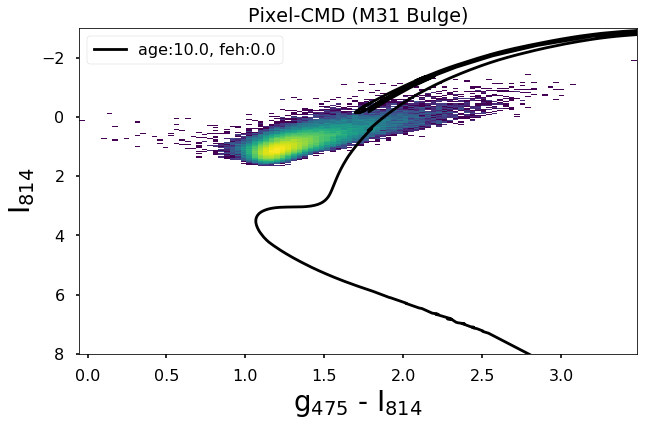

In [9]:
axis = plot_pcmd(pcmd_m31, title='Pixel-CMD (M31 Bulge)')
axis.set_ylim([8, -3.])
axis.legend(loc=0)

# The Basic Model

For a given population of stars (metallicity, Star-formation History, IMF), 

want to create a forward-model of the image and pixel-CMD

* use isochrones (magnitude, color, mass) from MIST

* assume each pixel in the image contains roughly $N_{pix}$ stars

* randomly populate the pixels with stars from the isochrones

* apply observational effects (dust extinction, HST PSF, ...)

* compare resulting pixel-CMD to observed data

In [10]:
m31_model = ppy.galaxy.DefaultTau.get_model(np.array([0., -2., 2.3, 2.5]), iso_step=-1)
pcmd_model, _ = driv.simulate(m31_model, 128)

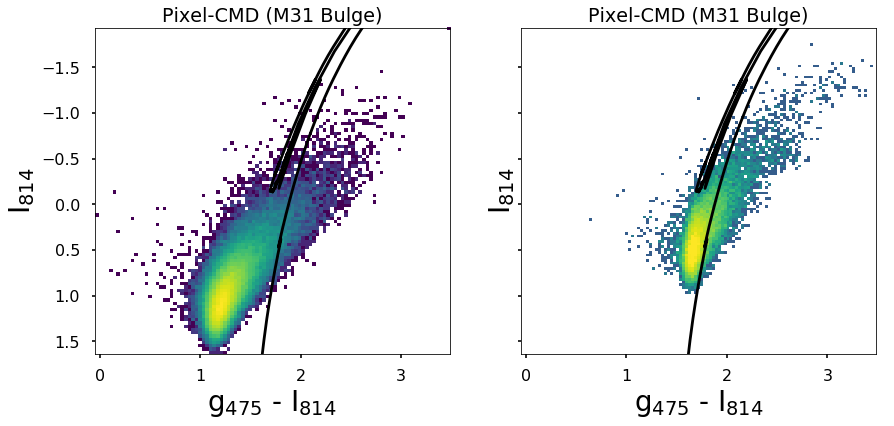

In [11]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 6), sharey=True, sharex=True)
plot_pcmd(pcmd_model, title='Pixel-CMD (M31 Bulge)', ax=axes[1])
plot_pcmd(pcmd_m31, title='Pixel-CMD (M31 Bulge)', ax=axes[0])


# Testing against Complex Data